In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')
data_df.head()

,training_set,y,dy,x
0,False,-3.751854,0.444200,AAAGCAAAA
1,True,-2.697741,0.369972,AAAGCAAAC
2,True,-2.242947,0.575121,AAAGCAAAG
3,False,-3.067251,0.357014,AAAGCAAAT
4,False,-2.987074,0.472637,AAAGCAACA


In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 17,498
testing N: 4,431


In [4]:
model_kwargs = {
    'regression_type':'GE',
    'L':L,
    'alphabet':'dna',
    'ge_nonlinearity_type':'nonlinear',
    'gpmap_type':'pairwise',
    'ge_noise_model_type':'SkewedT',
    'ge_heteroskedasticity_order':2
}

fit_kwargs={'learning_rate':.005,
            'epochs':1000,
            'batch_size': 200,
            'early_stopping': True,
            'early_stopping_patience': 30}

In [5]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(**model_kwargs)

# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

# Fit model to data
model.fit(**fit_kwargs)

N = 17,498 observations set as training data.
Data shuffled.
Time to set data: 0.37 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    17498 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.323e+02  4.299e+03   1.0e+00  2.5e-01
     1  2.19200e-02  1.200e+02  1.397e+03   9.1e-01  1.5e-01  7.7e+01  1.0e+00
     2  2.59784e-02  1.186e+02  7.118e+02   9.0e-01  5.2e-02  1.1e+02  1.1e+00
     3  2.96533e-02  1.184e+02  2.279e+02   9.0e-01  7.5e-03  2.6e+02  2.4e+00
     4  3.10860e-02  1.183e+02  5.410e+01   8.9e-01  1.7e-03  2.7e+02  3.1e+00
     5  3.20917e-02  1.183e+02  1.251e+01   8.9e-01  3.7e-04  2.8e+02  3.4e+00
     6  3.22692e-02  1.183e+02  1.248e+00   8.9e-01  3.7e-05  2.9e+02  3.5e+00
     7  3.22536e-02  1.183e+02  2.542e-01   8.9e-01  7.2e-06  3.

Epoch 48/1000
70/70 [==============================] - 0s 5ms/step - loss: 130.7999 - I_like: 0.3400 - val_loss: 132.6443 - val_I_like: 0.3123
Epoch 49/1000
70/70 [==============================] - 0s 6ms/step - loss: 130.8041 - I_like: 0.3401 - val_loss: 135.0142 - val_I_like: 0.2957
Epoch 50/1000
70/70 [==============================] - 0s 5ms/step - loss: 130.8527 - I_like: 0.3396 - val_loss: 132.2850 - val_I_like: 0.3150
Epoch 51/1000
70/70 [==============================] - 0s 5ms/step - loss: 130.1629 - I_like: 0.3449 - val_loss: 136.5818 - val_I_like: 0.2857
Epoch 52/1000
70/70 [==============================] - 0s 4ms/step - loss: 131.0892 - I_like: 0.3383 - val_loss: 133.8886 - val_I_like: 0.3042
Epoch 53/1000
70/70 [==============================] - 0s 4ms/step - loss: 131.3109 - I_like: 0.3366 - val_loss: 132.7256 - val_I_like: 0.3125
Epoch 54/1000
70/70 [==============================] - 0s 5ms/step - loss: 130.0884 - I_like: 0.3456 - val_loss: 135.4232 - val_I_like: 0.2912

In [6]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [7]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values
dy_test = test_df['dy'].values

On test data:
I_like_test: 0.318 +- 0.032 bits
I_pred_test: 0.379 +- 0.014 bits
I_intrinsic: 0.783 +- 0.023 bits
percent info explained: 48.3% +- 2.3%


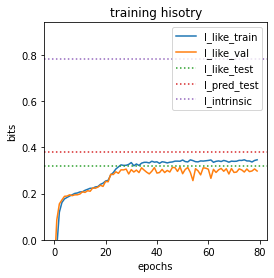

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Compute intrinsic information
I_intr, dI_intr = mavenn.I_intrinsic(y_values=y_test, dy_values=dy_test)
print(f'I_intrinsic: {I_intr:.3f} +- {dI_intr:.3f} bits')

# Compute percent info explained
pct = 100*I_pred/I_intr
dpct = 100*np.sqrt((dI_pred/I_intr)**2 + (dI_intr*I_pred/I_intr**2)**2)
print(f'percent info explained: {pct:.1f}% +- {dpct:.1f}%')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr, color='C4', linestyle=':', label='I_intrinsic')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_intr*1.2]);

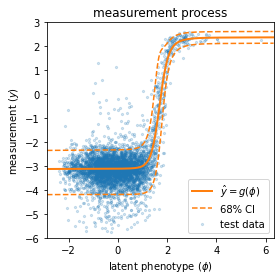

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.set_ylim([-6, 3])
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

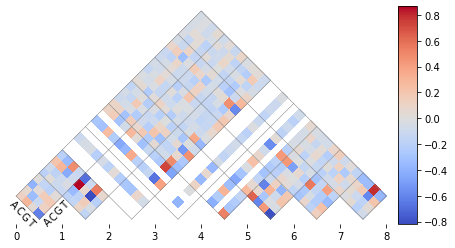

In [11]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);

In [12]:
# Test simulate_data
mavenn.set_seed(0)
sim_df = model.simulate_dataset(N=len(train_df))
mavenn.set_seed(1)
test_sim_df = model.simulate_dataset(N=len(test_df))
sim_df.head()

,training_set,yhat,phi,y,x
0,True,-3.113060,0.013231,-2.919330,GAAGCGTTA
1,True,-3.114115,-0.091740,-2.765360,GTGGTCAAA
2,True,-3.112779,0.037490,-3.373164,GTGGTTGCA
3,True,-3.115267,-0.236996,-3.837054,GTTGTTCGA
4,False,-3.108157,0.305026,-3.129803,CGTGTCTGA


In [13]:
# Set seeed
mavenn.set_seed(0)

# Define model
sim_model = mavenn.Model(**model_kwargs)

# Set training data
sim_model.set_data(x=sim_df['x'],
                   y=sim_df['y'])

# Fit model to data
sim_model.fit(**fit_kwargs)

N = 17,498 observations set as training data.
Data shuffled.
Time to set data: 0.417 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has    17498 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.323e+02  4.440e+03   1.0e+00  2.5e-01
     1  8.26059e-03  1.195e+02  1.480e+03   9.0e-01  1.6e-01  7.8e+01  1.0e+00
     2  1.27534e-02  1.182e+02  9.771e+02   8.9e-01  7.1e-02  1.2e+02  1.1e+00
     3  1.28360e-02  1.177e+02  1.609e+02   8.9e-01  5.2e-03  2.6e+02  2.1e+00
     4  1.27365e-02  1.177e+02  2.756e+01   8.9e-01  8.5e-04  2.7e+02  2.5e+00
     5  1.31882e-02  1.177e+02  4.335e+00   8.9e-01  1.3e-04  2.8e+02  2.6e+00
     6  1.31886e-02  1.177e+02  7.780e-01   8.9e-01  2.3e-05  2.9e+02  2.9e+00
     7  1.31902e-02  1.177e+02  3.908e-01   8.9e-01  9.3e-06  3

70/70 [==============================] - 1s 8ms/step - loss: 123.0798 - I_like: 0.4519 - val_loss: 122.4185 - val_I_like: 0.4495
Epoch 49/1000
70/70 [==============================] - 1s 8ms/step - loss: 124.5199 - I_like: 0.4412 - val_loss: 122.0189 - val_I_like: 0.4521
Epoch 50/1000
70/70 [==============================] - 0s 7ms/step - loss: 123.6775 - I_like: 0.4474 - val_loss: 121.2838 - val_I_like: 0.4566
Epoch 51/1000
70/70 [==============================] - 0s 7ms/step - loss: 122.8286 - I_like: 0.4537 - val_loss: 121.7004 - val_I_like: 0.4527
Epoch 52/1000
70/70 [==============================] - 1s 9ms/step - loss: 123.3363 - I_like: 0.4500 - val_loss: 122.4850 - val_I_like: 0.4468
Epoch 53/1000
70/70 [==============================] - 0s 6ms/step - loss: 124.0459 - I_like: 0.4450 - val_loss: 122.1348 - val_I_like: 0.4485
Epoch 54/1000
70/70 [==============================] - 0s 5ms/step - loss: 123.6446 - I_like: 0.4478 - val_loss: 121.4140 - val_I_like: 0.4543
Training time

On test data:
I_like_test: 0.425 +- 0.034 bits
I_pred_test: 0.447 +- 0.014 bits
I_intrinsic: 0.446 +- 0.032 bits


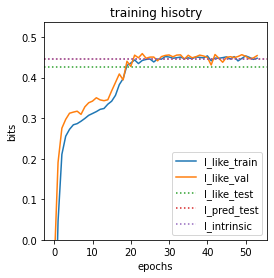

In [14]:
# Show training history
print('On test data:')

x_test = test_sim_df['x'].values
y_test = test_sim_df['y'].values

# Compute likelihood information
I_like, dI_like =  sim_model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = sim_model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Compute the intrinsic information, which is the likelihood information of the true mdoel
I_intr, dI_intr = model.I_likelihood(x=x_test, y=y_test)
print(f'I_intrinsic: {I_intr:.3f} +- {dI_intr:.3f} bits')

# Get history
I_like_hist = sim_model.history['I_like']
val_I_like_hist = sim_model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr, color='C4', linestyle=':', label='I_intrinsic')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, max([I_intr, I_like, I_pred])*1.2]);


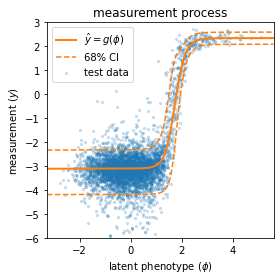

In [15]:
# Predict latent phentoype values (phi) on test data
phi_test = sim_model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = sim_model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = sim_model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = sim_model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.set_ylim([-6, 3])
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

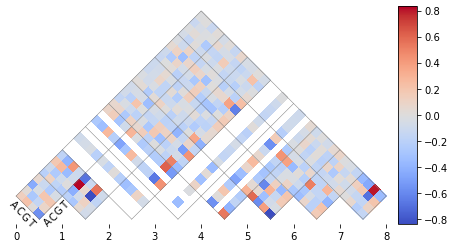

In [16]:
# Plot pairwise parameters
theta = sim_model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                        alphabet=theta['alphabet'],
                        ax=ax);